In [5]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

In [8]:
os.environ['SPARK_HOME']

'/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6'

In [9]:
spark = SparkSession.builder.master("local[2]").appName("pyspark-jupyter").getOrCreate()

In [10]:
spark

In [11]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=pyspark-jupyter>

In [12]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

In [13]:
FLIGHTS_TRAIN_DATA = 'data/flights20170102.json'
FLIGHTS_TEST_DATA = 'data/flights20170304.json'

In [14]:
schema = StructType([
    StructField("_id", StringType(), nullable=True),
    StructField("dofW", IntegerType(), nullable=True),
    StructField("carrier", StringType(), nullable=True),
    StructField("origin", StringType(), nullable=True),
    StructField("dest", StringType(), nullable=True),
    StructField("crsdephour", IntegerType(), nullable=True),
    StructField("crsdeptime", DoubleType(), nullable=True),
    StructField("depdelay", DoubleType(), nullable=True),
    StructField("crsarrtime", DoubleType(), nullable=True),
    StructField("arrdelay", DoubleType(), nullable=True),
    StructField("crselapsedtime", DoubleType(), nullable=True),
    StructField("dist", DoubleType(), nullable=True)]
  )

In [15]:
train_df = spark.read.json(path=FLIGHTS_TRAIN_DATA, schema=schema).cache()

In [16]:
train_df.count()

41348

In [17]:
train_df.show(5)

+--------------------+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|                 _id|dofW|carrier|origin|dest|crsdephour|crsdeptime|depdelay|crsarrtime|arrdelay|crselapsedtime|  dist|
+--------------------+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|AA_2017-01-01_ATL...|   7|     AA|   ATL| LGA|        17|    1700.0|     0.0|    1912.0|     0.0|         132.0| 762.0|
|AA_2017-01-01_LGA...|   7|     AA|   LGA| ATL|        13|    1343.0|     0.0|    1620.0|     0.0|         157.0| 762.0|
|AA_2017-01-01_MIA...|   7|     AA|   MIA| ATL|         9|     939.0|     0.0|    1137.0|    10.0|         118.0| 594.0|
|AA_2017-01-01_ORD...|   7|     AA|   ORD| MIA|        20|    2020.0|     0.0|      26.0|     0.0|         186.0|1197.0|
|AA_2017-01-01_LGA...|   7|     AA|   LGA| MIA|         7|     700.0|     0.0|    1017.0|     0.0|         197.0|1096.0|
+--------------------+----+-----

In [18]:
test_df = spark.read.json(path=FLIGHTS_TEST_DATA, schema=schema).cache()

In [19]:
test_df.count()

45448

In [20]:
test_df.show(5)

+--------------------+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|                 _id|dofW|carrier|origin|dest|crsdephour|crsdeptime|depdelay|crsarrtime|arrdelay|crselapsedtime|  dist|
+--------------------+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|WN_2017-03-01_ATL...|   3|     WN|   ATL| BOS|         9|     930.0|     0.0|    1155.0|     0.0|         145.0| 946.0|
|WN_2017-03-01_ATL...|   3|     WN|   ATL| BOS|        19|    1935.0|   243.0|    2215.0|   210.0|         160.0| 946.0|
|WN_2017-03-01_ATL...|   3|     WN|   ATL| BOS|        12|    1235.0|    11.0|    1505.0|     0.0|         150.0| 946.0|
|WN_2017-03-01_ATL...|   3|     WN|   ATL| DEN|        10|    1035.0|    28.0|    1200.0|    59.0|         205.0|1199.0|
|WN_2017-03-01_ATL...|   3|     WN|   ATL| DEN|        13|    1330.0|    16.0|    1450.0|    29.0|         200.0|1199.0|
+--------------------+----+-----

In [21]:
train_df.describe(["dist", "crselapsedtime", "depdelay", "arrdelay"]).show()

+-------+------------------+------------------+------------------+------------------+
|summary|              dist|    crselapsedtime|          depdelay|          arrdelay|
+-------+------------------+------------------+------------------+------------------+
|  count|             41348|             41348|             41348|             41348|
|   mean|1111.0529167069749|186.26264873754474|15.018719164167553|14.806907226468027|
| stddev| 568.7941212507543| 68.38149648990039| 44.52963204436135| 44.22370513266647|
|    min|             184.0|              64.0|               0.0|               0.0|
|    max|            2704.0|             423.0|            1440.0|            1442.0|
+-------+------------------+------------------+------------------+------------------+



## Data Exploration

We can use Spark SQL to explore the dataset. Here are some example queries using the Spark SQL:

### Register Dataset as a Temporary View in order to explore with SQL

In [22]:
train_df.createOrReplaceTempView("train_flights")

### Top 5 longest departure delays

In [23]:
# Top 5 longest departure delays programmatically
result_df = (train_df
                .select(["carrier", "origin", "dest", "depdelay", "crsdephour", "dist", "dofW"])
                .orderBy(["depdelay"], ascending=[0]).limit(5))

In [24]:
result_df.show()

+-------+------+----+--------+----------+------+----+
|carrier|origin|dest|depdelay|crsdephour|  dist|dofW|
+-------+------+----+--------+----------+------+----+
|     AA|   SFO| ORD|  1440.0|         8|1846.0|   3|
|     DL|   BOS| ATL|  1185.0|        17| 946.0|   6|
|     UA|   DEN| EWR|  1138.0|        12|1605.0|   4|
|     DL|   ORD| ATL|  1087.0|        19| 606.0|   7|
|     UA|   MIA| EWR|  1072.0|        20|1085.0|   1|
+-------+------+----+--------+----------+------+----+



In [25]:
# Top 5 longest departure delays using SQL
sql_result_df = spark.sql("SELECT carrier, origin, dest, depdelay, crsdephour, dist, dofW FROM train_flights ORDER BY depdelay DESC LIMIT 5")

In [26]:
sql_result_df.show()

+-------+------+----+--------+----------+------+----+
|carrier|origin|dest|depdelay|crsdephour|  dist|dofW|
+-------+------+----+--------+----------+------+----+
|     AA|   SFO| ORD|  1440.0|         8|1846.0|   3|
|     DL|   BOS| ATL|  1185.0|        17| 946.0|   6|
|     UA|   DEN| EWR|  1138.0|        12|1605.0|   4|
|     DL|   ORD| ATL|  1087.0|        19| 606.0|   7|
|     UA|   MIA| EWR|  1072.0|        20|1085.0|   1|
+-------+------+----+--------+----------+------+----+



### Average Departure Delay by Carrier

In [27]:
# Average Departure Delay by Carrier using SQL
sql_result_df = spark.sql("SELECT carrier, avg(depdelay) FROM train_flights GROUP BY carrier")

In [28]:
sql_result_df.show()

+-------+------------------+
|carrier|     avg(depdelay)|
+-------+------------------+
|     UA|17.477878450696764|
|     AA| 10.45768118831622|
|     DL|15.316061660865241|
|     WN|13.491000418585182|
+-------+------------------+



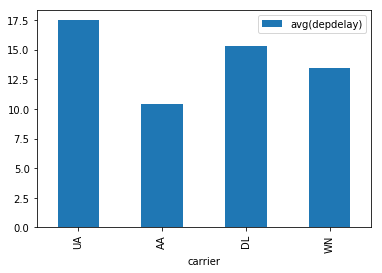

In [29]:
sql_result_df.toPandas().plot(kind='bar', x='carrier');

In [30]:
# Average Departure Delay by Carrier programmatically
result_df = (train_df
                .select(["carrier", "depdelay"])
                .groupBy(["carrier"])
                .avg("depdelay"))

In [31]:
result_df.show()

+-------+------------------+
|carrier|     avg(depdelay)|
+-------+------------------+
|     UA|17.477878450696764|
|     AA| 10.45768118831622|
|     DL|15.316061660865241|
|     WN|13.491000418585182|
+-------+------------------+



### Count of Departure Delays by Carrier (where delay>40 minutes)

We want to predict flight delays where depdelay > 40 minutes, so let’s explore this data. Below, we see that United Airlines and Delta have the highest count of flight delays for January and February 2017 (the training set).

In [32]:
# Count of Departure Delays by Carrier (where delay=40 minutes) using SQL
sql_result_df = spark.sql("SELECT carrier, count(depdelay) FROM train_flights WHERE depdelay > 40 GROUP BY carrier")

In [33]:
sql_result_df.show()

+-------+---------------+
|carrier|count(depdelay)|
+-------+---------------+
|     UA|           2420|
|     AA|            757|
|     DL|           1043|
|     WN|            244|
+-------+---------------+



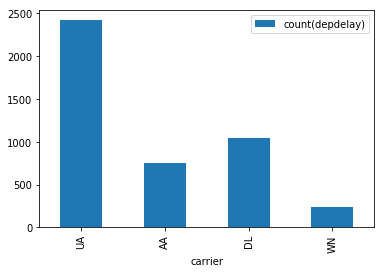

In [34]:
sql_result_df.toPandas().plot(kind='bar', x='carrier');

In [35]:
# Count of Departure Delays by Carrier (where delay=40 minutes) programmatically
result_df = (train_df
                .select(["carrier", "depdelay"])
                .where("depdelay > 40")
                .groupBy(["carrier"])
                .count())

In [36]:
result_df.show()

+-------+-----+
|carrier|count|
+-------+-----+
|     UA| 2420|
|     AA|  757|
|     DL| 1043|
|     WN|  244|
+-------+-----+



### Count of Departure Delays by Day of the Week (1=Monday, 7=Sunday)

In the query below, we see that Monday, Tuesday and Sunday have the highest count of flight delays.

In [37]:
### Count of Departure Delays by Day of the Week (where delay=40 minutes) using SQL
sql_result_df = spark.sql("SELECT dofW, count(depdelay) FROM train_flights WHERE depdelay > 40 GROUP BY dofW ORDER BY dofW")

In [38]:
sql_result_df.show()

+----+---------------+
|dofW|count(depdelay)|
+----+---------------+
|   1|            940|
|   2|            712|
|   3|            482|
|   4|            626|
|   5|            579|
|   6|            424|
|   7|            701|
+----+---------------+



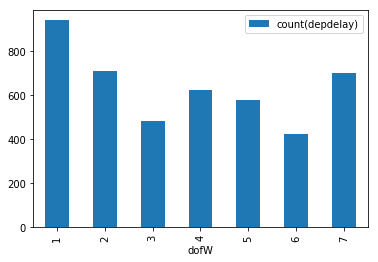

In [39]:
sql_result_df.toPandas().plot(kind='bar', x='dofW');

However, we can see that the days are marked as 1, 2, ... ,7 and not Monday, Tuesday, ... ,Sunday. We can develop a UserDefined function to get the custom labels. UDF (User defined functions) and UDAF (User defined aggregate functions) are key components of big data languages such as Pig and Hive. They allow to extend the language constructs to do adhoc processing on distributed dataset. This can be also applied to Spark. https://ragrawal.wordpress.com/2015/10/02/spark-custom-udf-example/

**Use UDF with DataFrames**

In [40]:
weekday = {1 : "Monday", 2 : "Tuesday", 3 : "Wednesday",  4 : "Thursday", 5 : "Friday", 6 : "Saturday", 7 : "Sunday"}

In [41]:
from pyspark.sql.functions import udf

# Define udf
udfdofwToweekday = udf(lambda x: weekday[x], StringType())

In [42]:
# Instead of a lambda function as in the above cell we could have also defined as a function and registered that as a udf
#def dofwToweekday(x):
#    return weekday[x]
#udfdofwToweekday = udf(dofwToweekday, StringType())

In [43]:
sql_result_df = sql_result_df.withColumn("weekday", udfdofwToweekday("dofW"))

In [44]:
sql_result_df.show()

+----+---------------+---------+
|dofW|count(depdelay)|  weekday|
+----+---------------+---------+
|   1|            940|   Monday|
|   2|            712|  Tuesday|
|   3|            482|Wednesday|
|   4|            626| Thursday|
|   5|            579|   Friday|
|   6|            424| Saturday|
|   7|            701|   Sunday|
+----+---------------+---------+



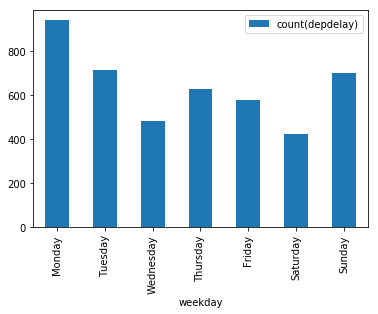

In [45]:
sql_result_df.toPandas()[['weekday', 'count(depdelay)']].plot(kind='bar', x='weekday');

Now we can see that days are marked by names.

In [46]:
# Count of Departure Delays by Day of the Week (where delay=40 minutes) programatically
# We can replicate same aliasing using programatic syntax
result_df = (train_df
                .select(["dofW", udfdofwToweekday("dofW").alias("weekday")])
                .where("depdelay > 40")
                .groupBy(["dofW", "weekday"])
                .count()
                .orderBy(["dofW"]))

In [47]:
result_df.show()

+----+---------+-----+
|dofW|  weekday|count|
+----+---------+-----+
|   1|   Monday|  940|
|   2|  Tuesday|  712|
|   3|Wednesday|  482|
|   4| Thursday|  626|
|   5|   Friday|  579|
|   6| Saturday|  424|
|   7|   Sunday|  701|
+----+---------+-----+



**Use UDF with SQL**

In [48]:
# in order to use an udf with sql it needs to be registerd to sqlContext
sqlContext.udf.register("udfdofwToweekday", lambda dofW: weekday[dofW], StringType())

In [49]:
### Count of Departure Delays by Day of the Week (where delay=40 minutes)
sql_result_df = spark.sql("SELECT dofW, udfdofwToweekday(dofW) as weekday, count(depdelay) FROM train_flights WHERE depdelay > 40 GROUP BY dofW, weekday ORDER BY dofW")

In [50]:
sql_result_df.show()

+----+---------+---------------+
|dofW|  weekday|count(depdelay)|
+----+---------+---------------+
|   1|   Monday|            940|
|   2|  Tuesday|            712|
|   3|Wednesday|            482|
|   4| Thursday|            626|
|   5|   Friday|            579|
|   6| Saturday|            424|
|   7|   Sunday|            701|
+----+---------+---------------+



### Count of Departure Delays by Hour of Day

In the query below, we see that the hours between 13:00-19:00 have the highest count of flight delays.

In [53]:
# Count of Departure Delays by Hour of Day using SQL
sql_result_df = spark.sql("SELECT crsdephour, count(depdelay) as total FROM train_flights WHERE depdelay > 40 GROUP BY crsdephour ORDER BY crsdephour")

In [54]:
sql_result_df.show()

+----------+-----+
|crsdephour|total|
+----------+-----+
|         0|    9|
|         1|    1|
|         5|   15|
|         6|   68|
|         7|  112|
|         8|  190|
|         9|  175|
|        10|  284|
|        11|  280|
|        12|  227|
|        13|  336|
|        14|  353|
|        15|  331|
|        16|  351|
|        17|  474|
|        18|  396|
|        19|  371|
|        20|  230|
|        21|  160|
|        22|   65|
+----------+-----+
only showing top 20 rows



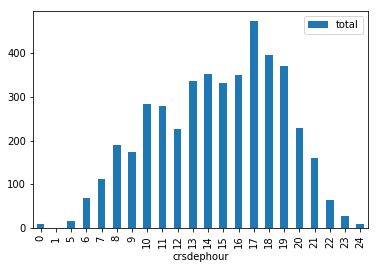

In [55]:
sql_result_df.toPandas().plot(kind='bar', x='crsdephour');

In [56]:
# Count of Departure Delays by Hour of Day using SQL programmatically
result_df = (train_df
                .select(["crsdephour", "depdelay"])
                .where("depdelay > 40")
                .groupBy(["crsdephour"])
                .count()
                .withColumnRenamed("count", "total")
                .orderBy(["crsdephour"], ascending=[1]))

In [57]:
result_df.show()

+----------+-----+
|crsdephour|total|
+----------+-----+
|         0|    9|
|         1|    1|
|         5|   15|
|         6|   68|
|         7|  112|
|         8|  190|
|         9|  175|
|        10|  284|
|        11|  280|
|        12|  227|
|        13|  336|
|        14|  353|
|        15|  331|
|        16|  351|
|        17|  474|
|        18|  396|
|        19|  371|
|        20|  230|
|        21|  160|
|        22|   65|
+----------+-----+
only showing top 20 rows



### Count of Departure Delays by Origin

In the query below, we see that the origin airports Chicago and Atlanta have the highest count of flight delays.

In [58]:
# Count of Departure Delays by Hour of Day using SQL
sql_result_df = spark.sql("SELECT origin, count(depdelay) as total FROM train_flights WHERE depdelay > 40 GROUP BY origin ORDER BY total desc")

In [59]:
sql_result_df.show()

+------+-----+
|origin|total|
+------+-----+
|   ORD|  679|
|   ATL|  637|
|   SFO|  542|
|   EWR|  518|
|   DEN|  484|
|   IAH|  447|
|   LGA|  432|
|   MIA|  429|
|   BOS|  296|
+------+-----+



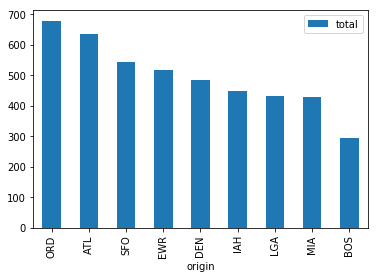

In [60]:
sql_result_df.toPandas().plot(kind='bar', x='origin');

In [61]:
# Count of Departure Delays by Hour of Day using SQL programmatically
result_df = (train_df
                .select(["origin", "depdelay"])
                .where("depdelay > 40")
                .groupBy(["origin"])
                .count()
                .withColumnRenamed("count", "total")
                .orderBy(["total"], ascending=[0]))

In [62]:
result_df.show()

+------+-----+
|origin|total|
+------+-----+
|   ORD|  679|
|   ATL|  637|
|   SFO|  542|
|   EWR|  518|
|   DEN|  484|
|   IAH|  447|
|   LGA|  432|
|   MIA|  429|
|   BOS|  296|
+------+-----+



### Count of Departure Delays by Destination

In the query below, we see that the destination airports San Francisco and Newark have the highest count of flight delays.

In [63]:
# Count of Departure Delays by Hour of Day using SQL
sql_result_df = spark.sql("SELECT dest, count(depdelay) as total FROM train_flights WHERE depdelay > 40 GROUP BY dest ORDER BY total desc")

In [64]:
sql_result_df.show()

+----+-----+
|dest|total|
+----+-----+
| SFO|  711|
| EWR|  620|
| ORD|  593|
| ATL|  547|
| LGA|  535|
| DEN|  397|
| MIA|  385|
| BOS|  343|
| IAH|  333|
+----+-----+



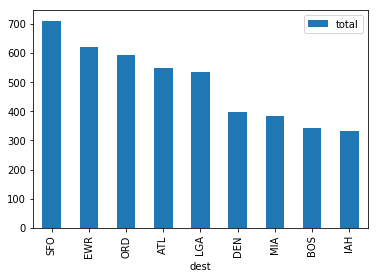

In [65]:
sql_result_df.toPandas().plot(kind='bar', x='dest');

In [66]:
# Count of Departure Delays by Hour of Day using SQL programmatically
result_df = (train_df
                .select(["dest", "depdelay"])
                .where("depdelay > 40")
                .groupBy(["dest"])
                .count()
                .withColumnRenamed("count", "total")
                .orderBy(["total"], ascending=[0]))

In [67]:
result_df.show()

+----+-----+
|dest|total|
+----+-----+
| SFO|  711|
| EWR|  620|
| ORD|  593|
| ATL|  547|
| LGA|  535|
| DEN|  397|
| MIA|  385|
| BOS|  343|
| IAH|  333|
+----+-----+



### Count of Departure Delays by Origin, Destination

In the query below, we see the count of departure delays by Origin and destination. The routes ORD -> SFO and DEN -> SFO have the highest delays, maybe because of weather in January and February. Adding weather to this dataset would give better results, but that is left as an exercise for the reader.

In [68]:
# Count of Departure Delays by Hour of Day using SQL
sql_result_df = spark.sql("SELECT origin, dest, count(depdelay) as total FROM train_flights WHERE depdelay > 40 GROUP BY origin, dest ORDER BY count(depdelay) desc")

In [69]:
sql_result_df.show()

+------+----+-----+
|origin|dest|total|
+------+----+-----+
|   DEN| SFO|  172|
|   ORD| SFO|  168|
|   ATL| LGA|  155|
|   ATL| EWR|  141|
|   SFO| DEN|  134|
|   LGA| ATL|  130|
|   ORD| EWR|  122|
|   SFO| ORD|  118|
|   EWR| ORD|  115|
|   ORD| LGA|  100|
|   IAH| SFO|   98|
|   IAH| EWR|   94|
|   MIA| LGA|   92|
|   ORD| ATL|   88|
|   LGA| ORD|   88|
|   ATL| SFO|   87|
|   LGA| MIA|   81|
|   SFO| EWR|   79|
|   EWR| SFO|   77|
|   ORD| DEN|   76|
+------+----+-----+
only showing top 20 rows



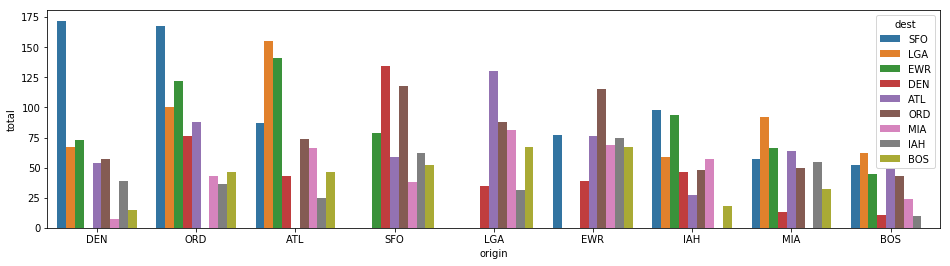

In [70]:
plt.figure(figsize=(16, 4))
sns.barplot(x="origin", y="total", hue="dest", data=sql_result_df.toPandas());

In [71]:
# Count of Departure Delays by Hour of Day using SQL programmatically
result_df = (train_df
                .select(["origin", "dest"])
                .where("depdelay > 40")
                .groupBy(["origin", "dest"])
                .count()
                .withColumnRenamed("count", "total")
                .orderBy(["total"], ascending=[0]))

In [72]:
result_df.show()

+------+----+-----+
|origin|dest|total|
+------+----+-----+
|   DEN| SFO|  172|
|   ORD| SFO|  168|
|   ATL| LGA|  155|
|   ATL| EWR|  141|
|   SFO| DEN|  134|
|   LGA| ATL|  130|
|   ORD| EWR|  122|
|   SFO| ORD|  118|
|   EWR| ORD|  115|
|   ORD| LGA|  100|
|   IAH| SFO|   98|
|   IAH| EWR|   94|
|   MIA| LGA|   92|
|   ORD| ATL|   88|
|   LGA| ORD|   88|
|   ATL| SFO|   87|
|   LGA| MIA|   81|
|   SFO| EWR|   79|
|   EWR| SFO|   77|
|   ORD| DEN|   76|
+------+----+-----+
only showing top 20 rows



## Add labels for Delayed Flights and Count

In the code below, a Spark Bucketizer is used to split the dataset into delayed and not delayed flights with a delayed 0/1 column. Then, the resulting total counts are displayed. Grouping the data by the delayed field and counting the number of instances in each group shows that there are roughly eight times as many not delayed samples as delayed samples.

In [73]:
train_df.show(5)

+--------------------+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|                 _id|dofW|carrier|origin|dest|crsdephour|crsdeptime|depdelay|crsarrtime|arrdelay|crselapsedtime|  dist|
+--------------------+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|AA_2017-01-01_ATL...|   7|     AA|   ATL| LGA|        17|    1700.0|     0.0|    1912.0|     0.0|         132.0| 762.0|
|AA_2017-01-01_LGA...|   7|     AA|   LGA| ATL|        13|    1343.0|     0.0|    1620.0|     0.0|         157.0| 762.0|
|AA_2017-01-01_MIA...|   7|     AA|   MIA| ATL|         9|     939.0|     0.0|    1137.0|    10.0|         118.0| 594.0|
|AA_2017-01-01_ORD...|   7|     AA|   ORD| MIA|        20|    2020.0|     0.0|      26.0|     0.0|         186.0|1197.0|
|AA_2017-01-01_LGA...|   7|     AA|   LGA| MIA|         7|     700.0|     0.0|    1017.0|     0.0|         197.0|1096.0|
+--------------------+----+-----

In [74]:
from pyspark.ml.feature import Bucketizer
bucketizer = Bucketizer(splits=[0.0, 40.0, float("inf")], inputCol="depdelay", outputCol="label")

In [75]:
train_df = bucketizer.transform(train_df)

In [76]:
train_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|36790|
|  1.0| 4558|
+-----+-----+



In [77]:
train_df.show(5)

+--------------------+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+-----+
|                 _id|dofW|carrier|origin|dest|crsdephour|crsdeptime|depdelay|crsarrtime|arrdelay|crselapsedtime|  dist|label|
+--------------------+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+-----+
|AA_2017-01-01_ATL...|   7|     AA|   ATL| LGA|        17|    1700.0|     0.0|    1912.0|     0.0|         132.0| 762.0|  0.0|
|AA_2017-01-01_LGA...|   7|     AA|   LGA| ATL|        13|    1343.0|     0.0|    1620.0|     0.0|         157.0| 762.0|  0.0|
|AA_2017-01-01_MIA...|   7|     AA|   MIA| ATL|         9|     939.0|     0.0|    1137.0|    10.0|         118.0| 594.0|  0.0|
|AA_2017-01-01_ORD...|   7|     AA|   ORD| MIA|        20|    2020.0|     0.0|      26.0|     0.0|         186.0|1197.0|  0.0|
|AA_2017-01-01_LGA...|   7|     AA|   LGA| MIA|         7|     700.0|     0.0|    1017.0|     0.0|         197.

### Create a stacked bar plot of count of departure delays by Origin

In the query below, we see the count of not delayed (0=dark blue) and delayed (1=light blue) flights by origin.

In [78]:
# Count of Departure Delays by Origin
result_df = (train_df
                .select(["origin", "label"])
                .groupBy(["origin", "label"])
                .count()
                .orderBy(["label"]))

In [79]:
result_df.show()

+------+-----+-----+
|origin|label|count|
+------+-----+-----+
|   LGA|  0.0| 4550|
|   MIA|  0.0| 3991|
|   IAH|  0.0| 3218|
|   BOS|  0.0| 3388|
|   ORD|  0.0| 5607|
|   DEN|  0.0| 3773|
|   EWR|  0.0| 3693|
|   ATL|  0.0| 5322|
|   SFO|  0.0| 3248|
|   LGA|  1.0|  442|
|   MIA|  1.0|  434|
|   IAH|  1.0|  455|
|   BOS|  1.0|  306|
|   ORD|  1.0|  693|
|   SFO|  1.0|  557|
|   EWR|  1.0|  526|
|   ATL|  1.0|  649|
|   DEN|  1.0|  496|
+------+-----+-----+



**Leverage Panda's pivot method to do a stacke dbar plot**

In [80]:
pdf = result_df.toPandas()
pdf

,origin,label,count
0,DEN,0.0,3773
1,BOS,0.0,3388
2,LGA,0.0,4550
3,EWR,0.0,3693
4,MIA,0.0,3991
5,IAH,0.0,3218
6,ORD,0.0,5607
7,ATL,0.0,5322
8,SFO,0.0,3248
9,LGA,1.0,442


**the table needs to be pivoted to create the bar plot**

In [82]:
pdf = pdf.pivot(index='origin', columns='label', values='count').sort_index()
pdf

label,0.0,1.0
origin,,
ATL,5322,649
BOS,3388,306
DEN,3773,496
EWR,3693,526
IAH,3218,455
LGA,4550,442
MIA,3991,434
ORD,5607,693
SFO,3248,557


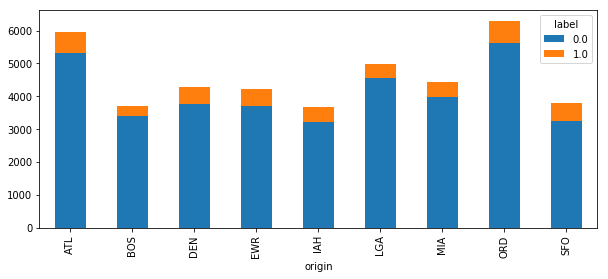

In [83]:
pdf.plot.bar(stacked=True, figsize=(10, 4));

**can we do the same pivot using Spark?**

In [84]:
# careful! we are using train_df and not result_df
train_df.select(["origin", "label"]).groupBy(["origin"]).pivot('label').count().orderBy('origin').show()

+------+----+---+
|origin| 0.0|1.0|
+------+----+---+
|   ATL|5322|649|
|   BOS|3388|306|
|   DEN|3773|496|
|   EWR|3693|526|
|   IAH|3218|455|
|   LGA|4550|442|
|   MIA|3991|434|
|   ORD|5607|693|
|   SFO|3248|557|
+------+----+---+



Voila! The same result as above from pandas dataframe pivot method

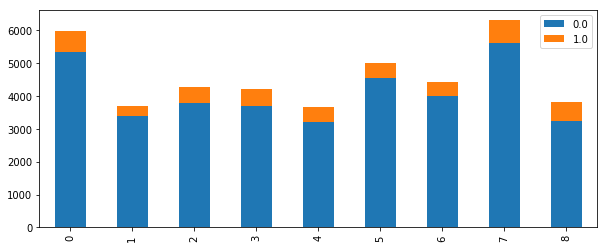

In [85]:
train_df.select(["origin", "label"]).groupBy(["origin"]).pivot('label').count().orderBy('origin').toPandas().plot.bar(stacked=True, figsize=(10, 4));

In [86]:
spark.stop()